In [1]:
import pyrtools as pt
import numpy as np
import stimuli
%matplotlib inline
import seaborn as sns
import pandas as pd
from scipy import signal
import json
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The following demonstrates some of the stimuli that can be made with the `log_polar_grating` command. The key characteristic of these stimuli is that the frequency (in cycles per pixel) increases as you approach the center of the image. This encodes our hypothesis that the preferred spatial frequency of neurons (and thus, voxels) whose receptive fields are located at the fovea (here, the center of the image) will have a higher preferred spatial frequency than those whose receptive fields are located in the periphery.

However, with these parameters, we notice that there is strange-looking aliasing happening in the center of the image.

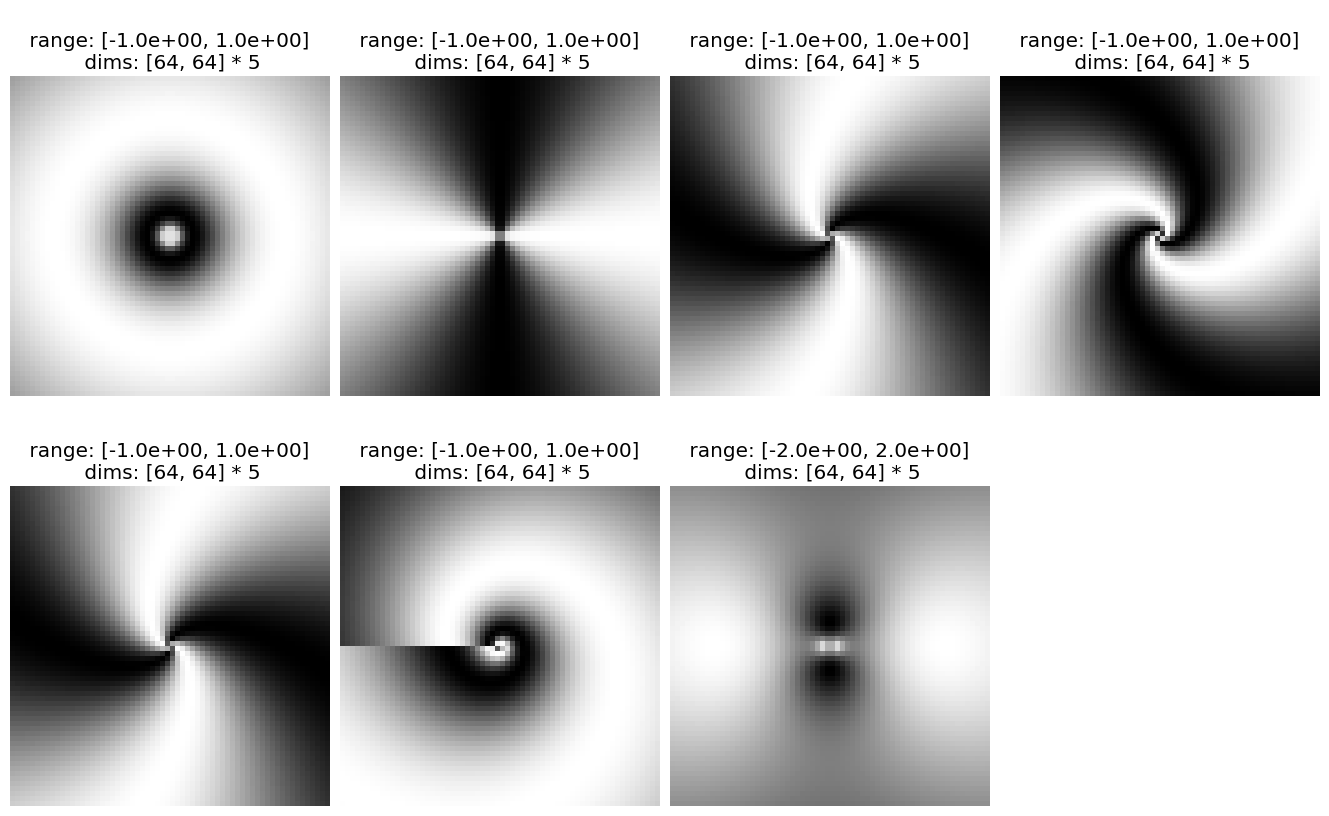

In [2]:
ims = []
freq=2
phase = 0
ampl=1
shape=64
origin = None
ims.append(stimuli.log_polar_grating(shape, freq,phi=phase,ampl=ampl, origin=origin))
ims.append(stimuli.log_polar_grating(shape, w_a=freq,phi=phase,ampl=ampl))
ims.append(stimuli.log_polar_grating(shape, freq/2,freq,phi=phase,ampl=ampl))
ims.append(stimuli.log_polar_grating(shape,-freq,freq,phi=phase,ampl=ampl))
ims.append(stimuli.log_polar_grating(shape,freq/2,freq,phi=phase,ampl=ampl))
ims.append(stimuli.log_polar_grating(shape,freq,freq/4,phi=phase,ampl=ampl))
ims.append(ims[0]+ims[1])
# ims.append(sfp.stimuli._create_better_sampled_grating(shape, freq, phi=phase, ampl=ampl, orig_origin=origin, check_scale_factor=3))
# ims.append(sfp.stimuli._create_better_sampled_grating(shape, w_a=freq, phi=phase, ampl=ampl, orig_origin=origin, check_scale_factor=3))
# ims.append(sfp.stimuli._create_better_sampled_grating(shape, freq, phi=phase, ampl=ampl, check_scale_factor=50, orig_origin=origin))
# ims.append(sfp.stimuli._create_better_sampled_grating(shape, freq, phi=phase, ampl=ampl, check_scale_factor=200, orig_origin=origin))

# Example stimuli
pt.imshow(ims, col_wrap=min(len(ims), 4),zoom=5);

In order to investigate this a little more, we create compare the second, radial stimulus with a more heavily-sampled version.

The first plot shows the central slice of the 64 x 64 image in orange and the central slice of the grating 11 times larger in blue. We clearly see some very high frequency signal that is being missed.

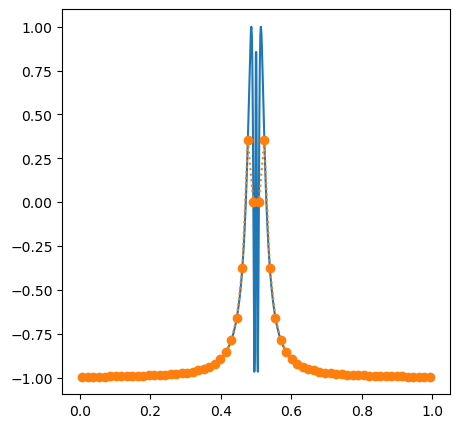

In [3]:
stim, over_sampled_stim = stimuli.check_aliasing(64, 0, w_a=6, check_scale_factor=11)

This second plot shows the two images, and again we can see the aliasing at the center

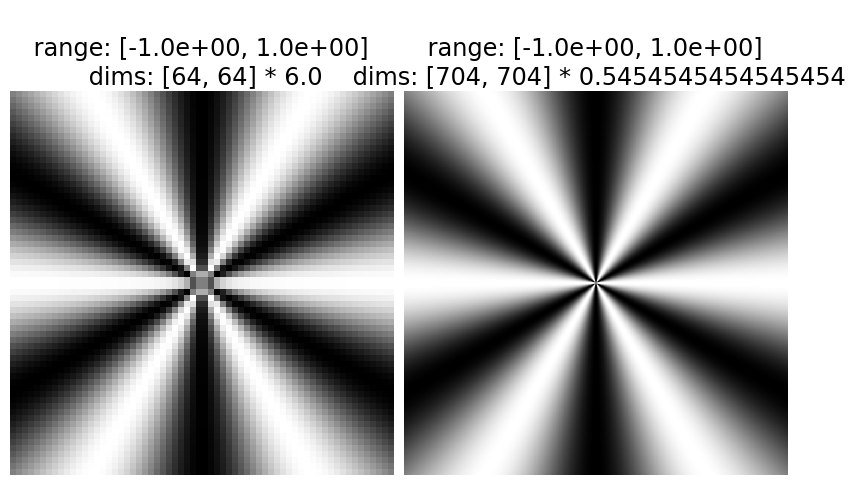

In [4]:
pt.imshow([stim, over_sampled_stim], zoom=6/11);

To deal with this issue, we create a mask that we'll lay at the center of the image, completely masking out the aliased portion of the stimuli and then fading gradually to invisible as we move away from it.

This first plot shows the same slice as above for the un-masked, fade-masked, and binary-masked stimuli.

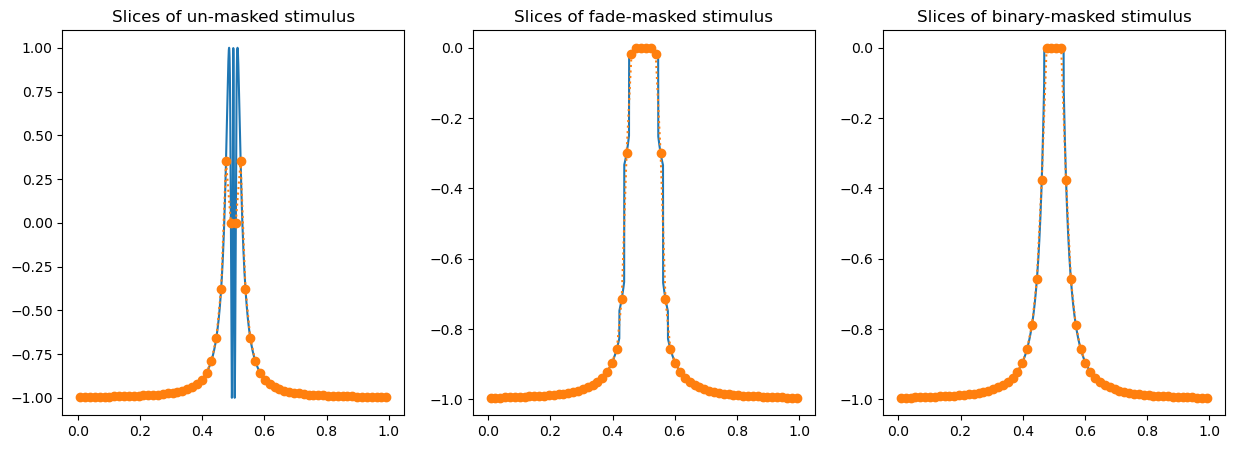

In [5]:
tmps = stimuli.check_aliasing_with_mask(64, 0, w_a=6, )

This here shows the 64 x 64 image with no mask, the faded mask, and the binary mask. We can see that the masking hides the aliased portion of the image.

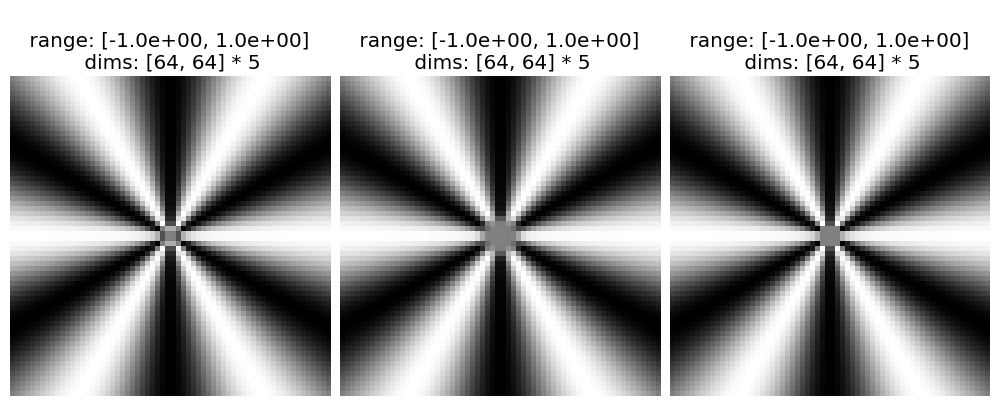

In [6]:
pt.imshow([tmps[0], tmps[1] * tmps[0], tmps[2] * tmps[0]], col_wrap=3, zoom=5);

Now that we know the stimuli we want to create and are convinced that masking takes care of their aliasing, we can create the set of stimuli for experiment. We do this using the `gen_stim_set` function, which requires that the `size`, `origin`, and `number_of_fade_pixels` parameters be constant across all stimuli, but allows the others to vary. We create all the stimuli and then apply the largest mask to them, so that all stimuli have the same mask and none show any aliasing. The function returns both the unmasked (`stim`) and masked (`mstim`) versions of the stimuli, but we only want the masked versions (the unmasked are only returned so they can be double-checked).

The following two plots show an example set of (smaller) stimuli and one full-sized one.

To create the exact set of stimuli wanted for the experiment, use the `stimuli.main` function (but note that this can take some time and will save the outputs; it can also be run on the command-line).

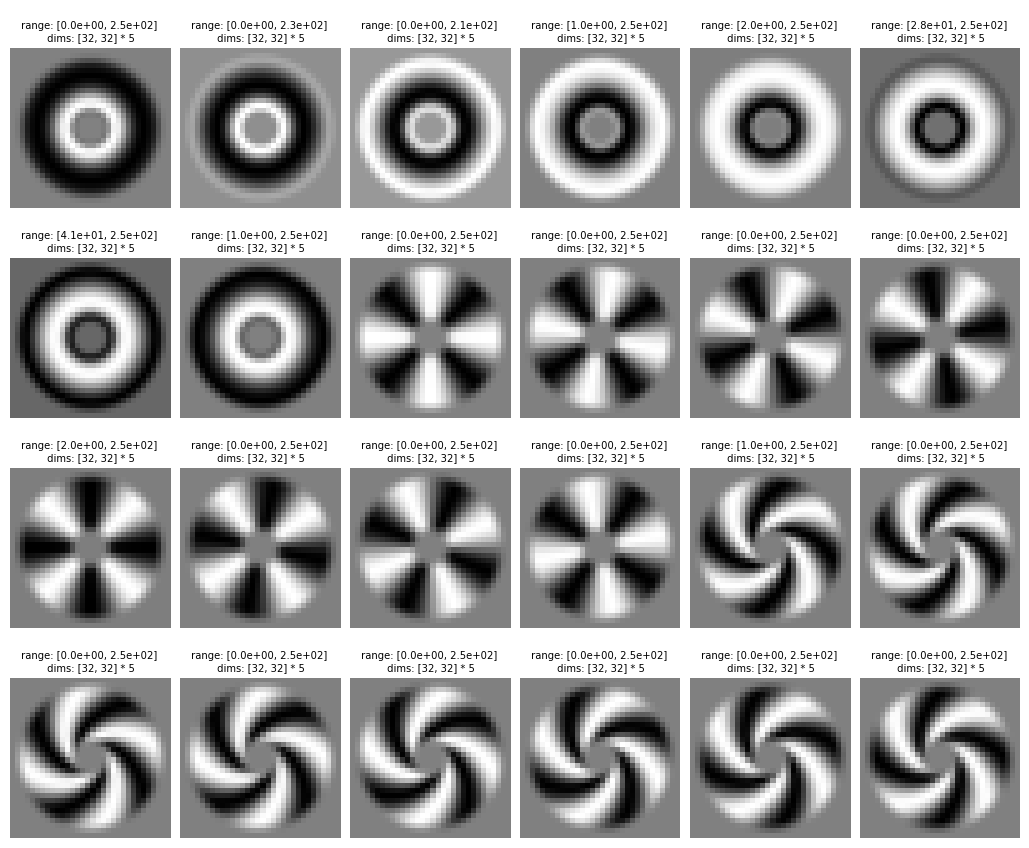

In [7]:
mstim, stim, mask = stimuli.gen_log_polar_stim_set(32, freqs_ra=[(4,0),(0,4),(4,4)], phi=np.array(range(8))/8.*2*np.pi, )
# mstim is a list of lists of arrays, we need to flatten it into a list of arrays for display purposes.
mstim_display = []
for ms in mstim:
    mstim_display += ms
pt.imshow(mstim_display, col_wrap=6, zoom=5);

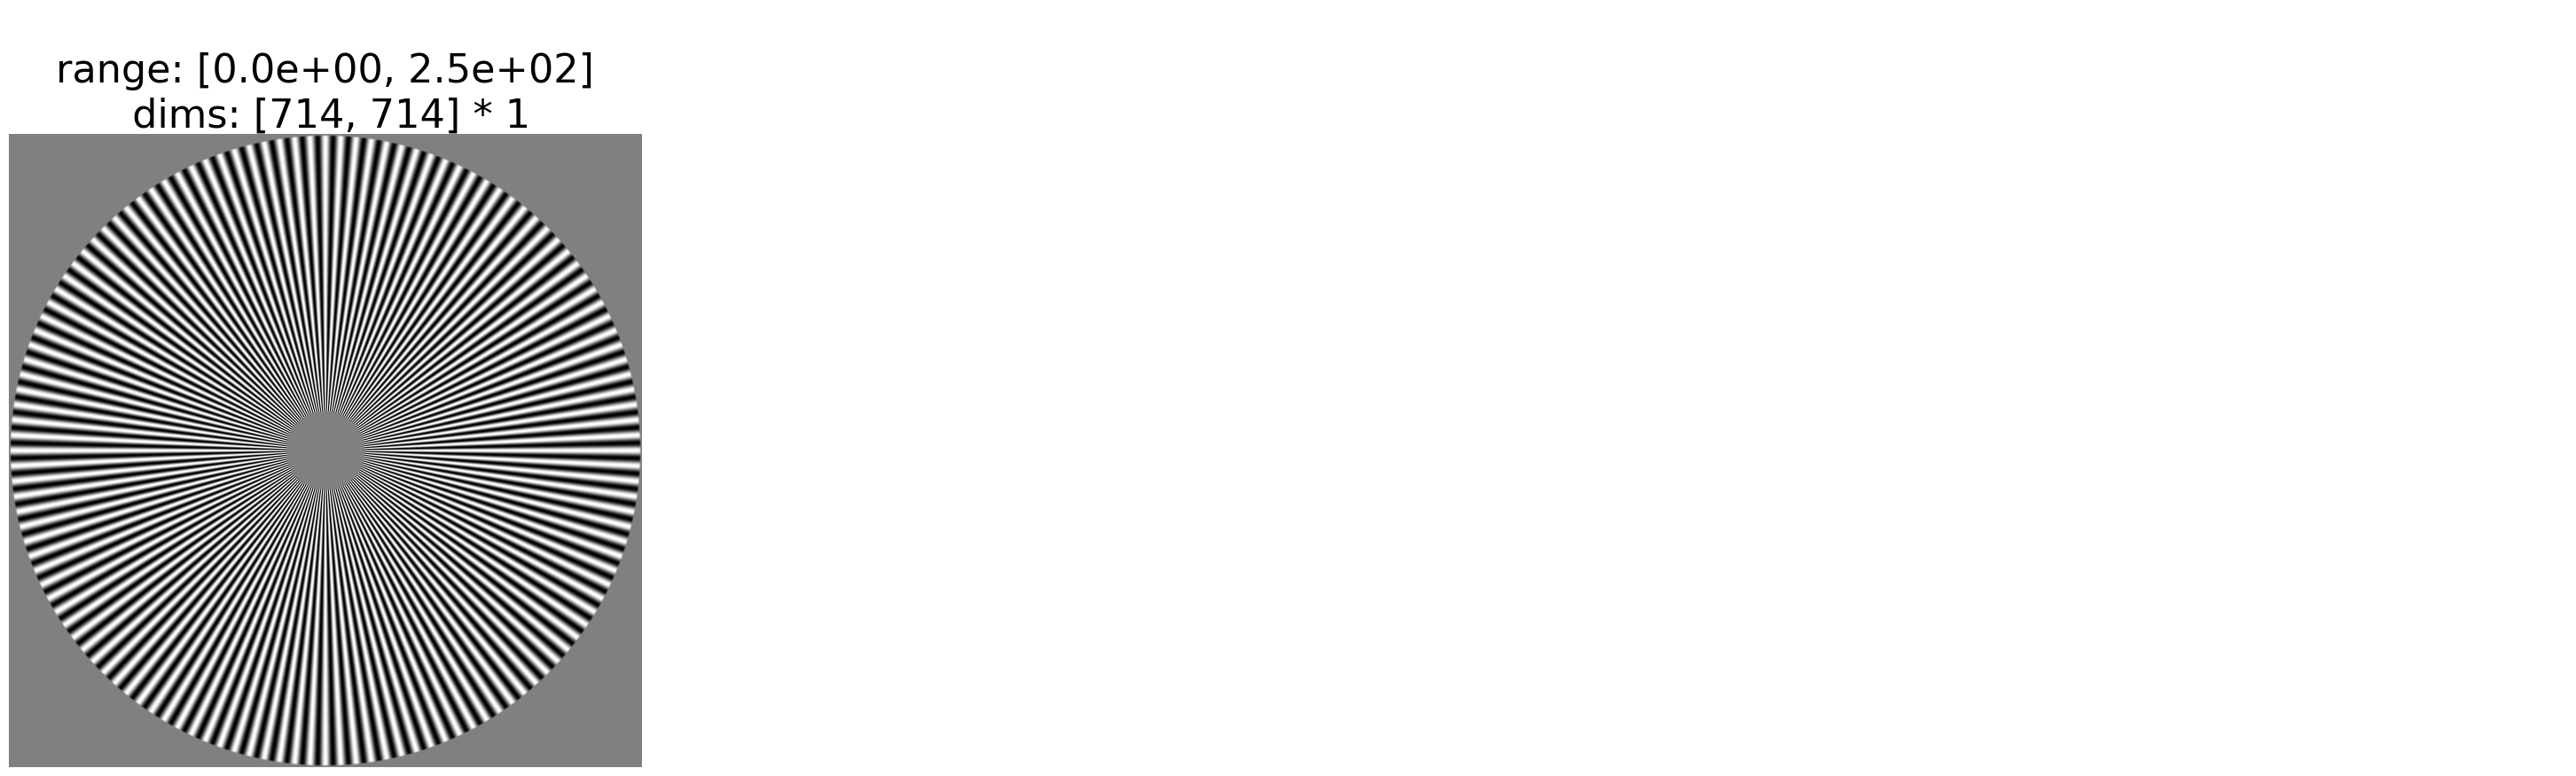

In [8]:
mstim, _, _ = stimuli.gen_log_polar_stim_set(714, [(0, 128)], bytescale=True)# phi=np.array(range(10))/10.*2*np.pi, )

pt.imshow(mstim[0], col_wrap=4, );

# Stimulus properties

For the purposes of creating our stimuli, we're interested in a couple of numbers that aren't apparent from the plots above:

 - how big the anti-aliasing mask in the center will be
 - what the minimum spatial frequency in the stimulus will be
 - what the maximum spatial frequency (after applying the mask) will be

for the spatial frequencies, we're interested in this in units of cycles per visual degree, so we create the full-size stimulus (714 x 714 pixels) and input the diameter of the stimulus in visual degrees (8.4).

In [9]:
# Note that this takes a while to run
mask_df, sf_df = stimuli.check_stim_properties(714, None, 8.4, w_r=range(0, 300, 10), w_a=range(0, 300, 10))

We see that the mask grows with the frequencies. It gets pretty big.

Note that the mask size is *only* dependent on the frequency content the image, not the size of the image. So if you have $\omega_a=290$ and $\omega_r==0$, your mask will always be about 100 pixels wide, so if your image is only 150 pixels per side, then your entire image will be blank. 

/home/billbrod/miniforge3/envs/sf-stim/lib/python3.7/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/billbrod/Documents/spatial-frequency-stimuli/stimuli.py:841: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  g.fig.tight_layout(rect=[0, 0, .9, .95])


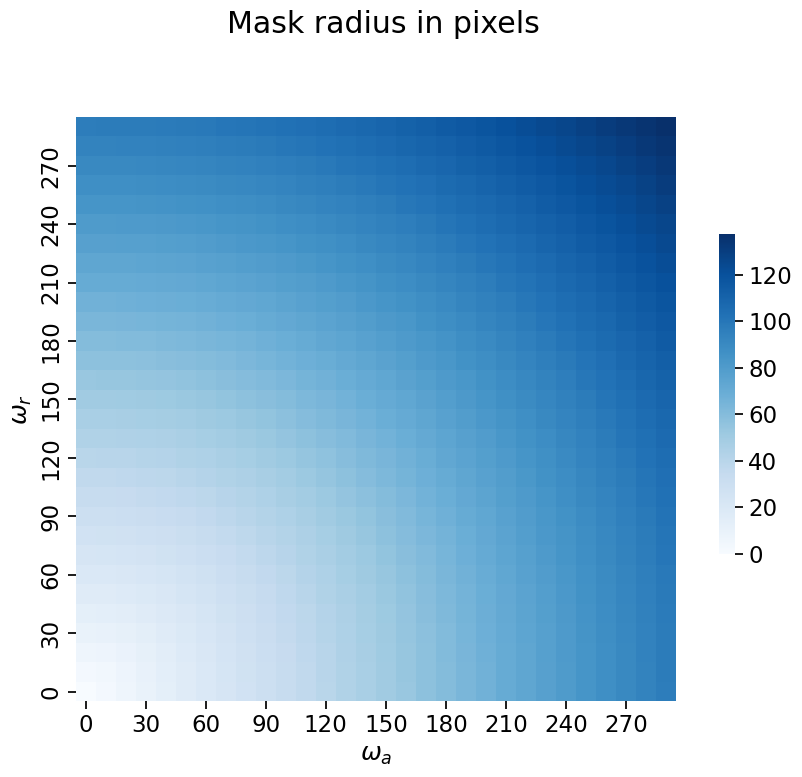

In [10]:
stimuli.plot_stim_properties(mask_df, height=8)

This next plot isn't as interesting, but it's a sanity check to make sure the mask is working: basically, we want to see that the mask is working and so nowhere do we get frequencies exceeding .5 cycles per pixel. This shows that that's the case: no matter how high the frequencies go in either direction, they always stay below .5

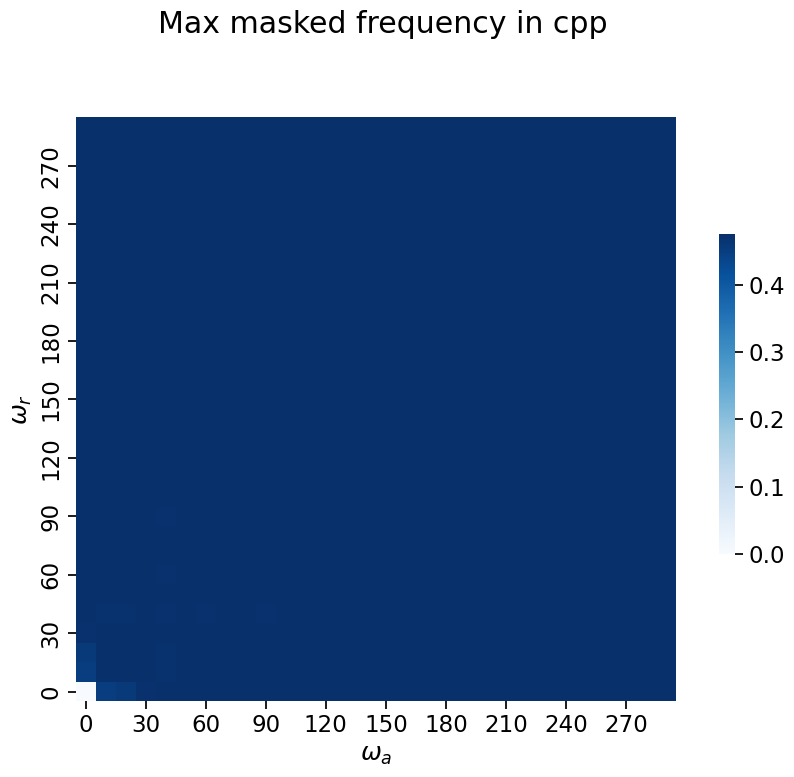

In [11]:
stimuli.plot_stim_properties(mask_df, data_label='cpp_masked_max', title_text="Max masked frequency in cpp", height=8)

The code automatically calculates what the size of the anti-aliasing mask should be (and can return the masked stimuli to you, if you use `gen_log_polar_stim_set`), but we do not mask the stimuli. Instead, we create a json file that gives the radius we think the anti-aliasing mask should have (by masking out all those places where the image has a spatial frequency less than .475 cycles per pixel, slightly below the Nyquist limit because we *really* don't want aliasing) in degrees and in pixels.

# Constant stimuli

We also want to create stimuli whose local spatial frequency is the same everywhere, i.e., normal 2d sine waves. To compare them effectively to our stimuli, we construct the spatial frequency dataframe.

Because only the distance from the origin in frequency space matters (as discussed above), we set $\omega_r$ to 0 and only look at different values of $\omega_a$, for simplicity. We also use the actual values we will use in this experiment: $\omega_a=[2^{2.5}, 2^3, 2^{3.5}, 2^4, 2^{4.5}, 2^5, 2^{5.5}, 2^6, 2^{6.5}, 2^7]$. We use these values rounded to the nearest integer, because they need to be integers in order to not have weird discontinuities

In order to determine what spatial frequencies are constant grating stimuli should have, we look at the local period (which is equivalent to looking at the local spatial frequency, since they're just reciprocals of each other, and more interpretable) at eccentricity 4.5 degrees. If we construct a constant grating with those periods, we guarantee that at one eccentricity we have the same local spatial frequency in both sets of stimuli. We choose 4.5 because then there are roughly equal numbers of larger and smaller log polar gratings.

Note that we do this whole process (without the figure) in `stimuli.main`, this is just so you can see the figure and get a sense for what we're doing.

In [12]:
_, sf_df = stimuli.check_stim_properties(714, None, 8.4, 0, np.round([2**i for i in np.linspace(2.5, 7, 6, endpoint=True)]))

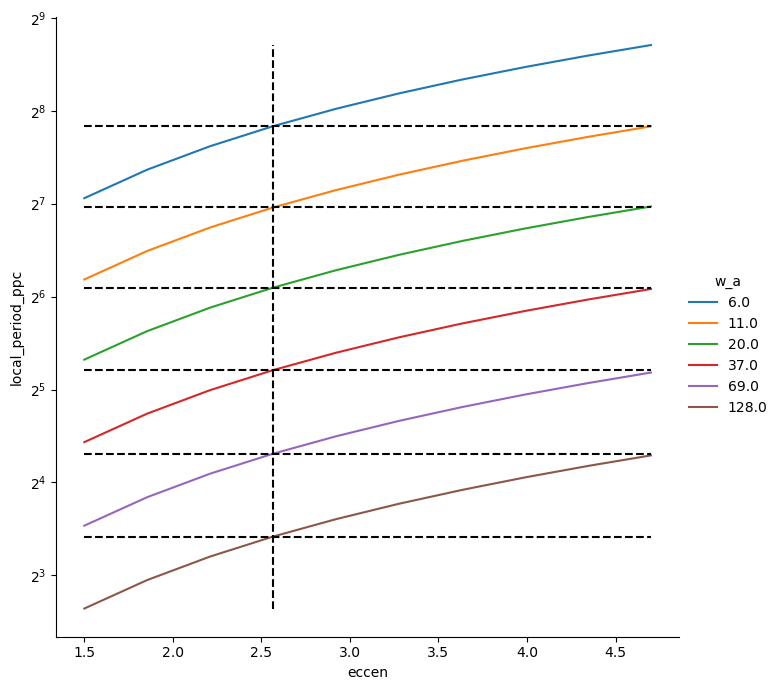

In [13]:
target_eccen = 2.5
# we won't have exactly this eccentricity in the dataframe because of how we sample the space, so this grabs the closest one
sf_df_eccen = sf_df.eccen.unique()[np.abs(sf_df.eccen.unique()-2.5).argmin()]
plot_func = [plt.plot, plt.semilogy]
plot_kwargs = [{}, {'base': 2}]
plot_idx = 1
g = sns.FacetGrid(sf_df, hue='w_a', height=7)
g.map(plot_func[plot_idx], 'eccen', 'local_period_ppc', **plot_kwargs[plot_idx])
g.add_legend()
constant_grads = sf_df[sf_df.eccen==sf_df_eccen].local_period_ppc.values
for val in constant_grads:
    plot_func[plot_idx]([sf_df.eccen.min(), sf_df.eccen.max()], [val, val], 'k--', **plot_kwargs[plot_idx])
plot_func[plot_idx]([sf_df_eccen, sf_df_eccen], [sf_df.local_period_ppc.min(), sf_df.local_period_ppc.max()], 'k--', **plot_kwargs[plot_idx])

Unfortunately, these numbers are ugly, but they're the ones we want to use.

In [14]:
# since these come from the period, we grab their reciprocal for the spatial frequency
print(1./constant_grads)
print(np.log2(1./constant_grads))

[0.0043832  0.00803587 0.01461068 0.02702976 0.05040684 0.09350835]
[-7.83379851 -6.95932939 -6.09683292 -5.20930765 -4.31023656 -3.41876101]



# Experiment stimuli

Your stimuli should be created from the command line (in the `spatial_frequency_preferences` directory, call `python -m sfp.stimuli -h` to view the helpstring), but this here loads in the unshuffled stimuli and descriptive dataframe and examines some of them.

In [15]:
stim = np.load("data/stimuli/task-sfp_stimuli.npy")
df = pd.read_csv("data/stimuli/task-sfp_stim_description.csv")
constant_stim = np.load("data/stimuli/task-sfpconstant_stimuli.npy")
constant_df = pd.read_csv("data/stimuli/task-sfpconstant_stim_description.csv")
with open('data/stimuli/task-sfp_mask.json') as f:
    mask_json = json.load(f)

The stimuli are `pixel_diameter * pixel_diameter * n_classes * n_exemplars`

In [16]:
stim.shape

(714, 714, 28, 8)

In [17]:
constant_stim.shape

(714, 714, 48, 8)

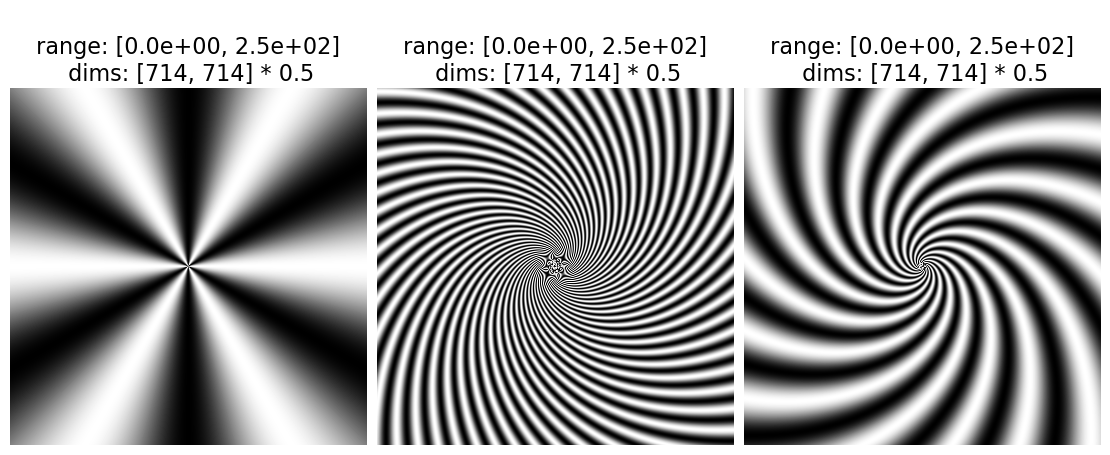

In [18]:
pt.imshow([stim[:,:,0,0], stim[:,:,10,0], stim[:,:,20,0]], zoom=.5);

Notice there's heavy aliasing for the high frequency stimuli. That's why we have the information saved in mask_json:

In [19]:
mask_json

{'mask_radius_degrees': 0.5084378773271717,
 'mask_radius_pixels': 43.15669125408017}

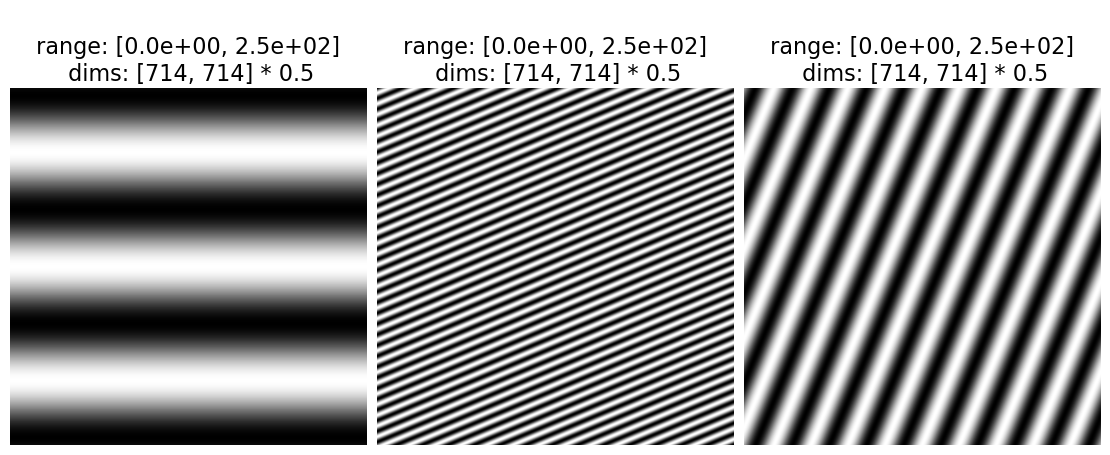

In [20]:
pt.imshow([constant_stim[:,:,0,0], constant_stim[:,:,10,0], constant_stim[:,:,20,0]], zoom=.5);

In order to better understand what stimuli you're seeing, check the stimulus description dataframe. `class_idx` corresponds to the third index, `phase_idx` to the fourth.

In [21]:
df.head()

,w_r,w_a,phi,res,class_idx,phase_idx
0,0.0,6.0,0.000000,714,0,0
1,0.0,6.0,0.785398,714,0,1
2,0.0,6.0,1.570796,714,0,2
3,0.0,6.0,2.356194,714,0,3
4,0.0,6.0,3.141593,714,0,4


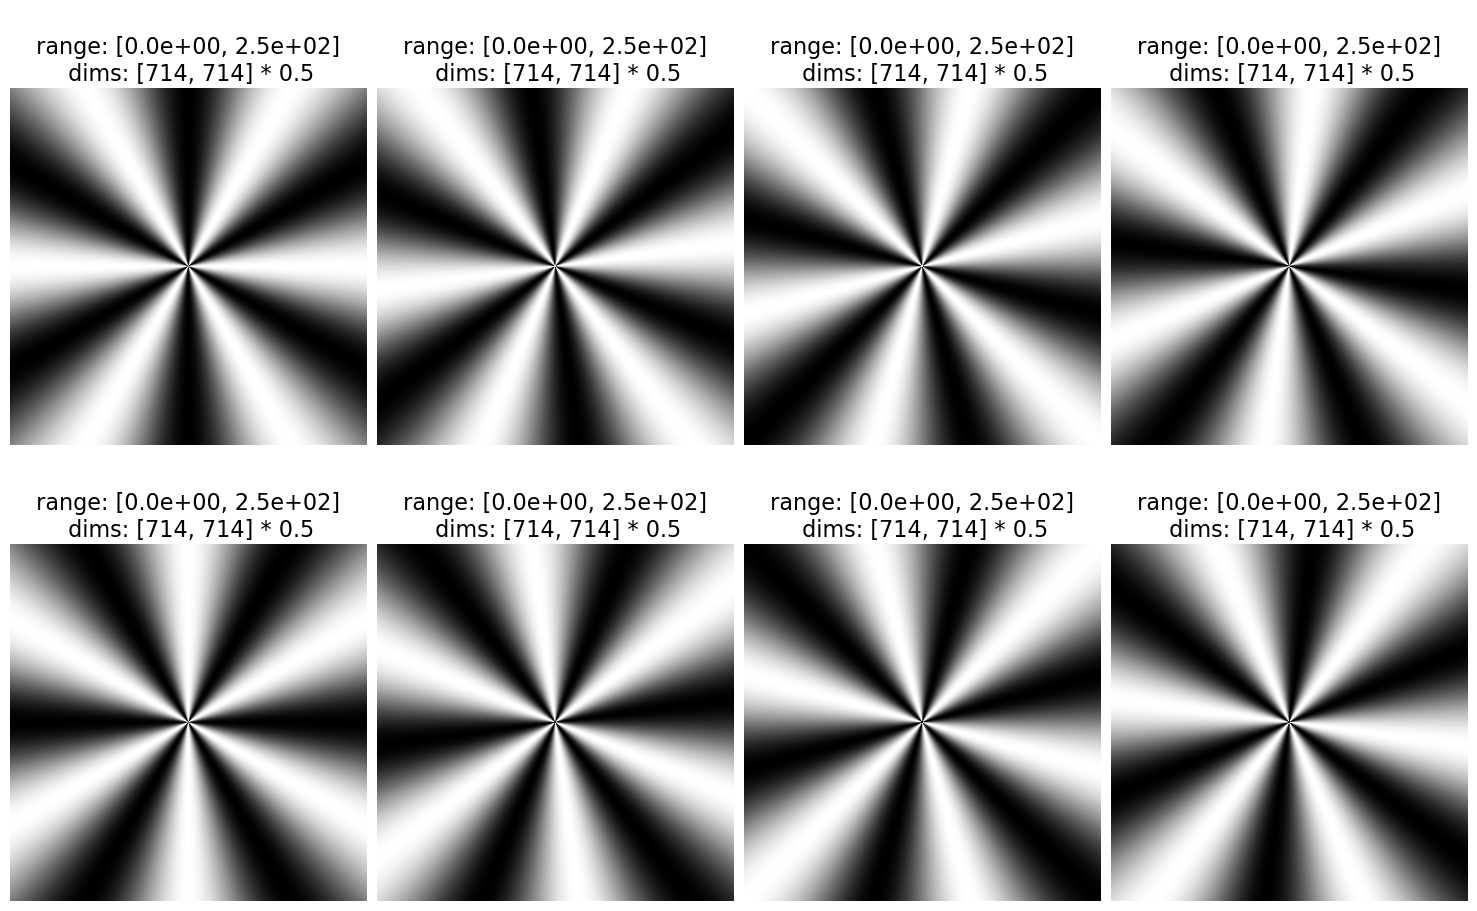

In [22]:
# note we have to transpose this so that the first dimension indexes different images, and then iterate through it
pt.imshow([s for s in stim[:,:,0,:].transpose(2,0,1)], col_wrap=4, zoom=.5);

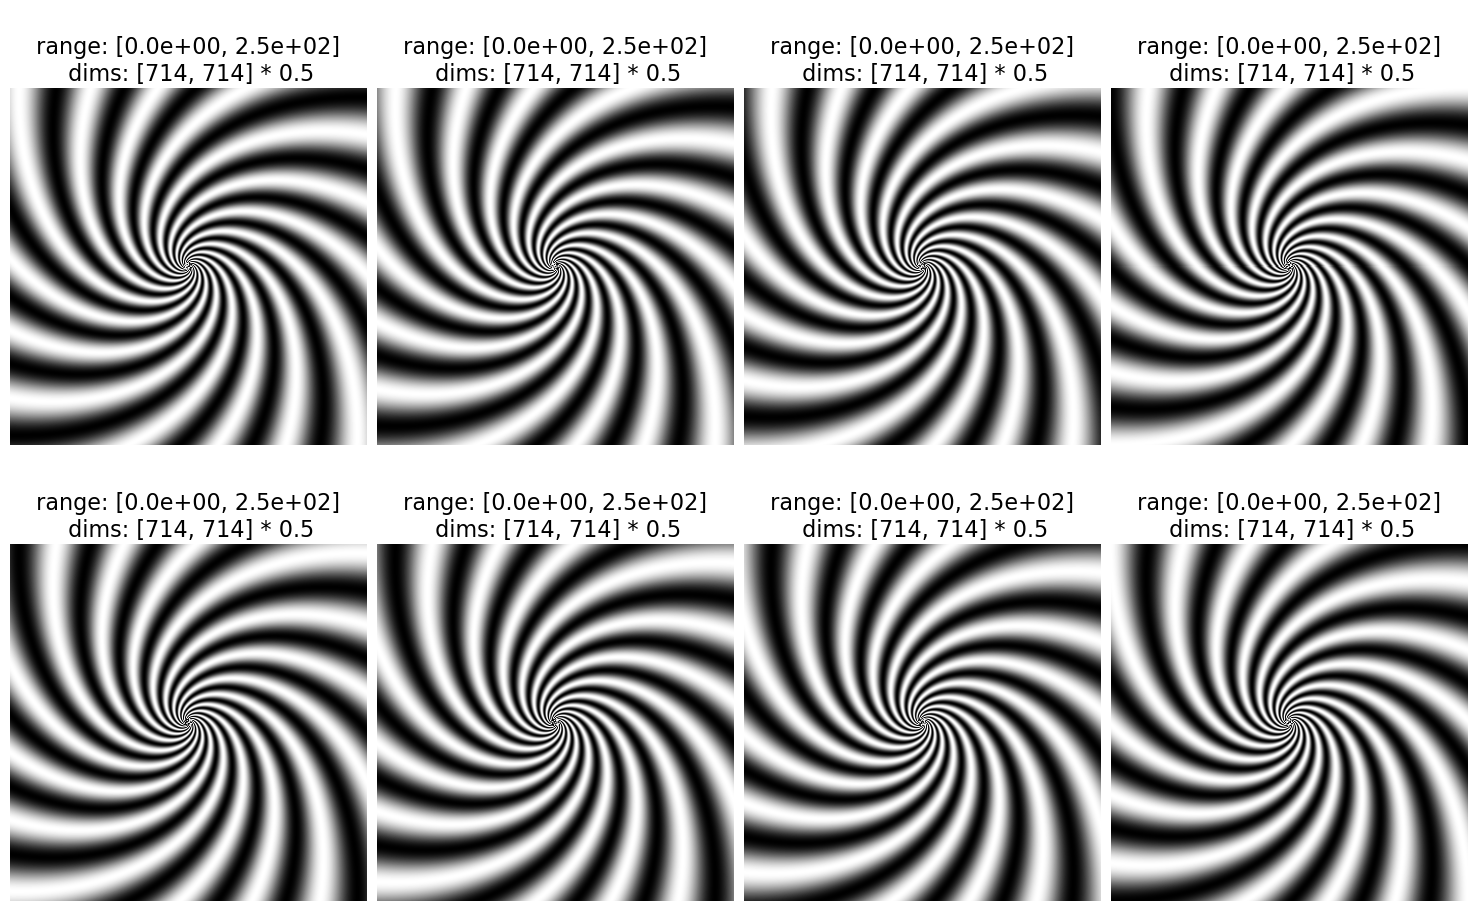

In [23]:
# note we have to transpose this so that the first dimension indexes different images, and then iterate through it
pt.imshow([s for s in stim[:,:,20,:].transpose(2,0,1)], col_wrap=4, zoom=.5);

# Calculating the spatial frequency of the stimuli

We also include some helper functions for calculating the local spatial frequency of the stimuli, which you will probably want for analyses of this data. Note that, for this, the phase information doesn't matter.

Note that for the following, orientation is in absolute terms (such that 0 means "to the right"), which is probably what you expect. We also include functions that calculate orientation in retinal-relative terms (such that 0 means "away form the fovea"). They are `sf_origin_polar_cpd` and `create_sf_origin_polar_maps_cpd`. Similarly, the following give spatial frequency in cycles per degree. If you want it in cycles per pixel, replace `cpd` with `cpp` in the fucntion names.

First, pick a stimulus:

In [24]:
class_idx = np.random.randint(0, high=df.class_idx.max())
tmp = df.query('class_idx==@class_idx').drop_duplicates('class_idx')
tmp

,w_r,w_a,phi,res,class_idx,phase_idx
104,11.0,0.0,0.0,714,13,0


Now let's pick a location in the visual field:

In [25]:
rands = np.random.rand(2)
eccen = 7.4 * rands[0]
angle = 2*np.pi * rands[1]
print("Eccentricity: %.03f degrees" % eccen)
print("Angle: %.03f radians" % angle)

Eccentricity: 0.617 degrees
Angle: 3.322 radians


In [26]:
dx, dy, mag, direc = stimuli.sf_cpd(eccen, angle, w_r=tmp.w_r.unique()[0], w_a=tmp.w_a.unique()[0])
print("Spatial frequency: %.03f cpd" % mag)
print("Orientation: %.03f radians" % direc)

Spatial frequency: 2.837 cpd
Orientation: 3.322 radians


We can also get a map of the spatial frequency of a given stimulus. However, the spatial frequency map won't look like much because the frequency is so much higher in the center of the image. If you were to mask out the center (where it's aliasing), then this image would be more meaningful.

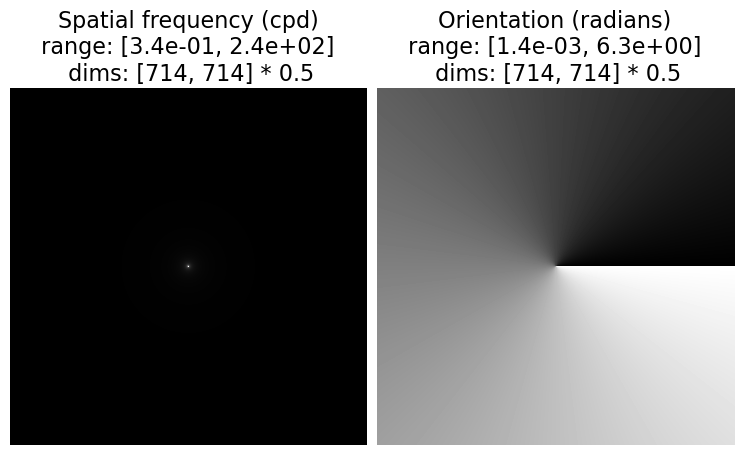

In [27]:
dx, dy, mag, direc = stimuli.create_sf_maps_cpd(w_r=tmp.w_r.unique()[0], w_a=tmp.w_a.unique()[0])
pt.imshow([mag, direc], zoom=.5, title=['Spatial frequency (cpd)', "Orientation (radians)"]);